# Plot scaling with the histogram of the duration

Plot the stats of the moment-duration diagram with the log-linear fitting to show the non-self-similarity.

2024.11.28 Kurama Okubo

- 2024.11.30 update for the log linear fitting
- 2024.12.3 update for the fitting with log linear function.
- 2025.1.31 update plot dynamic rupture result


In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal, stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
from matplotlib.ticker import FixedLocator
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec

from scipy import interpolate
from scipy.optimize import curve_fit  
import matplotlib as mpl
import pickle
import copy

import seaborn as sns 
from scipy.interpolate import LSQUnivariateSpline
from scipy import integrate
from scipy.interpolate import CubicSpline

import h5py # store the STF in hdf5
from scipy.optimize import minimize

from shapely.geometry import Point # use to find the data in the interval
from shapely.geometry.polygon import Polygon


from STFfit_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False #True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

In [2]:
datadir = "../data/07_loglinearfit/"
if not os.path.exists(datadir):
    os.makedirs(datadir)

figdir = "../figure/07_loglinearfit/"
if not os.path.exists(figdir):
    os.makedirs(figdir)


# Read the STF stats

In [3]:
gougepatch_id = "G3" # to set output filename
denoise_method = "detrend"
Qinv_quart = 50
k_waterlevel = 0.3

# fo = h5py.File(f"../data/03_computePdisp/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'r+')

expr_id = 87
foname_all = f"../data/05_STFstats/SourceParam_allsensors_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_sourceparam = pd.read_csv(foname_all, index_col=0)

foname_mean = f"../data/05_STFstats/SourceParam_meanstd_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_stats = pd.read_csv(foname_mean, index_col=0)

# Fitting the function

In [4]:
# select the stats rows
Nvalidsensors_thresh = 4

df_stats_case = df_stats[(df_stats["Qinv_quart"] == f"{Qinv_quart}") & (df_stats["Nvalidsensors"] >= Nvalidsensors_thresh)].copy()

df_stats_case["Tw_microsec"] = df_stats_case["Tw_mean"]*1e6
df_stats_case
df_stats_case = df_stats_case.set_index("gougeevent_id")
# remove the events near the measurement limitation
remove_eventlist = [118, 126]
df_stats_case_droplim = df_stats_case.drop(index = remove_eventlist) # events without limit events
df_stats_case_limevent = df_stats_case.loc[remove_eventlist, :] # removed events


In [5]:
df_stats_case_limevent

,datacase,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std,Tw_microsec
gougeevent_id,,,,,,,,
118,fb03-087__0118,50,4,0.076079,0.010126,0.000002,2.221314e-07,2.001607
126,fb03-087__0126,50,4,0.017021,0.002538,0.000002,2.955030e-07,1.991559


## Read the case without Q correction

In [6]:
df_stats_noQcorr = df_stats[df_stats["Qinv_quart"] == "noQcorr"].copy()
# synchronize the events with the Q corrected case
case_inds = [x in df_stats_case.index.values for x in df_stats_noQcorr["gougeevent_id"]]
df_stats_noQcorr = df_stats_noQcorr.loc[case_inds, :]
df_stats_noQcorr["Tw_microsec"] = df_stats_noQcorr["Tw_mean"]*1e6
assert (df_stats_noQcorr.gougeevent_id == df_stats_case.index).all()

## Tips for log-linear fitting

It causes the difference with the curve fit to the linear scaled data with $y = c x^{\alpha}$ and $\log{y} = \log{c} + \alpha\log{x}$. We selected the fitting with the latter form as follows:

$$ Y = \beta + \alpha X, $$
$Y = \log{y}$, $\beta = \log{c}$, $X = \log{x}$. Then, 
$$ y = c x ^ {\alpha} $$

$y = T_R$ and $x = M_0$ in our application. 

We estimate $\alpha$ and $\beta$ by the fitting.

See also https://stackoverflow.com/questions/64632563/difference-between-exponential-fit-and-log-linear-fit.


In [7]:
df_stats_case_droplim.head()

,datacase,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std,Tw_microsec
gougeevent_id,,,,,,,,
4,fb03-087__0004,50,4,0.592607,0.178671,0.000003,1.530315e-07,2.558865
9,fb03-087__0009,50,4,0.046991,0.007419,0.000002,3.643121e-07,2.346274
18,fb03-087__0018,50,4,0.755830,0.192507,0.000003,3.100882e-07,2.865571
19,fb03-087__0019,50,4,0.055755,0.016951,0.000002,2.699155e-07,2.484483
20,fb03-087__0020,50,4,0.865466,0.210250,0.000003,1.352659e-07,2.766240


In [8]:
# Y = np.log10(df_stats_case_droplim["Tw_mean"].values)
Y = np.log10(df_stats_case_droplim["Tw_microsec"].values)
X = np.log10(df_stats_case_droplim["M0_mean"].values)

In [9]:
Y

array([0.40804738, 0.37037866, 0.45721123, 0.39523601, 0.44188986,
       0.36360949, 0.39173032, 0.40596296, 0.41229593, 0.35301641,
       0.33473272, 0.37365603, 0.3888673 , 0.41144783, 0.41523198,
       0.41734884, 0.40507971, 0.32471692, 0.41597978, 0.42039601,
       0.36035629, 0.3826263 , 0.39403673, 0.4429868 , 0.47024782,
       0.46475158, 0.44678079, 0.44088598, 0.34856286, 0.41935145,
       0.39737887])

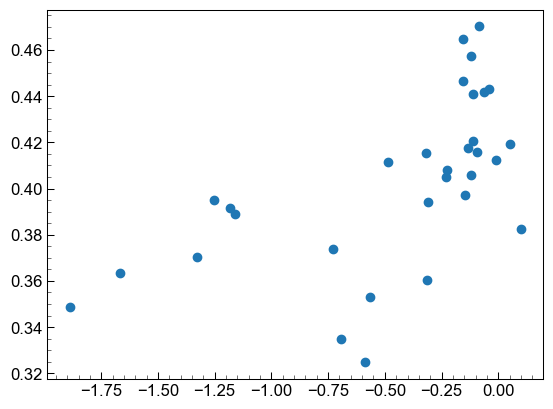

In [10]:
plt.plot(X, Y, "o")

### Dump the data

We dump the data to perform type II linear regression using `lmodel2` in R.

In [11]:
data_tofit = pd.DataFrame(data=[X, Y], index=["X", "Y"]).T
data_tofit.head()

,X,Y
0,-0.227233,0.408047
1,-1.327985,0.370379
2,-0.121576,0.457211
3,-1.253713,0.395236
4,-0.062750,0.441890


In [12]:
data_tofit.to_csv(datadir+f"/logfitdata_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv",
                  index=False, float_format='%12.8f')

# Run the R script

Run `source('R07_compute_loglinfit.R')` to perform the major axis fitting. Note that SMA/RMA normalize the M0 and Tw range to be std of 1, which may be inappropriate for our use.

# Load the dumped data

In [13]:
colnames = ["Method", "Intercept", "Slope", "Angle(degrees)", "P-perm(1-tailed)"]
df_res = pd.read_csv("../data/07_loglinearfit/lmodel2_out_regression.txt", sep=' ',
                     names=colnames, skipinitialspace=True, skiprows=1, header=None)
# change the column name as angle includes a white space

df_conf = pd.read_csv("../data/07_loglinearfit/lmodel2_out_confidence.txt", sep=' ', skipinitialspace=True)
df_res = df_res.set_index("Method")
df_conf = df_conf.set_index("Method")

In [14]:
df_res

,Intercept,Slope,Angle(degrees),P-perm(1-tailed)
Method,,,,
OLS,0.421241,0.041295,2.364668,0.01
MA,0.421301,0.041427,2.372213,0.01
SMA,0.434312,0.069963,4.002071,NaN
RMA,0.433318,0.067782,3.877706,0.01


In [15]:
df_conf

,2.5%-Intercept,97.5%-Intercept,2.5%-Slope,97.5%-Slope
Method,,,,
OLS,0.406361,0.436120,0.019846,0.062744
MA,0.411497,0.431123,0.019923,0.062968
SMA,0.425998,0.445557,0.051728,0.094626
RMA,0.420002,0.455421,0.038578,0.116261


In [16]:
fit_method="MA"
fit_slope = df_res.loc[fit_method, "Slope"]
fit_slope_low = df_conf.loc[fit_method, "2.5%-Slope"]
fit_slope_high = df_conf.loc[fit_method, "97.5%-Slope"]
fit_slope_err = (fit_slope_high - fit_slope_low)/2
print(f"slope with major axis regression is {fit_slope:.4f} ± {fit_slope_err:.4f}.")

slope with major axis regression is 0.0414 ± 0.0215.


In [17]:
fit_difference_ratio = (1-df_res.loc["OLS", "Slope"]/df_res.loc["MA", "Slope"])*100
print(f"Fitting slope difference between OLS and MA is {fit_difference_ratio:.4}%" )

Fitting slope difference between OLS and MA is 0.3184%


# Plot data with log linear fitting

In [18]:
def get_selfsim_scaling(k, beta, delsig, M0):
    return (1/(k*beta)) * (7/(16*delsig))**(1/3) * M0**(1/3)

def M02Mw(M0):
    return (np.log10(M0) - 9.1) * 2.0 / 3.0 # synchronized with OpenSWPC : moment_magnitude ( m0 )

def Mw2M0(Mw):
    return 10**( 1.5 * Mw + 9.05) # synchronized with OpenSWPC : seismic_moment ( mw )
   

In [19]:
# compute regression
M0_reg = np.logspace(-3, 1, 101)
TR_reg = (10**df_res.loc[fit_method, "Intercept"])*(M0_reg**df_res.loc[fit_method, "Slope"])

TR_reg_low = (10**df_conf.loc[fit_method, "2.5%-Intercept"])*(M0_reg**df_conf.loc[fit_method, "2.5%-Slope"])
TR_reg_high = (10**df_conf.loc[fit_method, "97.5%-Intercept"])*(M0_reg**df_conf.loc[fit_method, "97.5%-Slope"])

In [20]:
skipcolor = 2
datacases_thresh_Nsensor = df_stats_case["datacase"].values
lc_selected = dict()
c_norm = mpl.colors.Normalize(vmin=0, vmax=len(datacases_thresh_Nsensor)+skipcolor)
cmap = sns.color_palette("tab20", as_cmap=True) # for tab 20 not ordering to distribute the color
for i, datacase in enumerate(datacases_thresh_Nsensor):
    lc_selected[datacase] = cmap(c_norm(i+skipcolor))


In [21]:
# lc_selected

In [22]:
# selected AE sensors for patch G3
AEsensor_list = ["OL23", "OL07", "OL08", "OL22"] # update: we use 4 close sensors "OL24"] 
gougeevent_id = 4
stnm = AEsensor_list[0]
df_sourceparam[(df_sourceparam["Qinv_quart"] == f"{Qinv_quart}") & (df_sourceparam["gougeevent_id"] ==  gougeevent_id) & (df_sourceparam["AEsensor"] ==  int(stnm[2:]))]

,expr_id,datacase,gougeevent_id,AEsensor,Qinv_quart,M0,Tw,Tshift,stf_type,peakSTFamp,fitting_flag,error_fraction,error_thresh,RMSE,SNR_sensor,SNR_thresh,validflag
index,,,,,,,,,,,,,,,,,
fb03-087__OL23,fb03-087,fb03-087__0004,4,23,50,0.359696,0.000003,2.670094e-08,cosine,284758.897,True,0.005793,0.06,1649.66709,15.188115,4.5,1


In [23]:
# df_stats_case

## Standard error

We plot the error bar with the standard error with is computed as follows:
$$ STE = \dfrac{\sigma}{\sqrt{N_{\text{sensor}}}}, $$ 

Where the N sensor is thresholded as four.

In [24]:
sorted_inds = np.argsort(df_stats_case.M0_mean.values)

In [25]:
scatter_mc = sns.color_palette("tab10")
scatter_mc

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [26]:
dynrup_col = sns.color_palette("colorblind")
dynrup_col

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [27]:
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL08" # the color dict is same for all the sensor although separately saved.
gougepatch_id = "G3"
with open(f'../data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

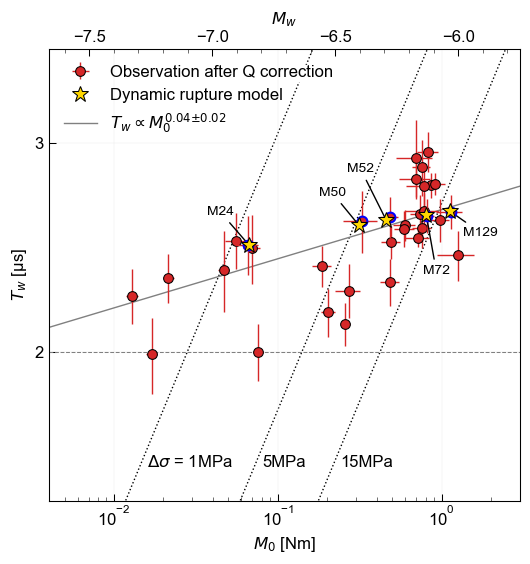

In [28]:
ifPlotSelfSimLines = True
vs=3600
n_boot = 1000

fig, ax = plt.subplots(1, 1, figsize=(5.46, 5.8))

scatter_kws0 = {"s": 0, "edgecolors": "k", "zorder": 1, "alpha": 0.9}
scatter_kws1 = {"s": 90, "edgecolors": "k", "zorder": 1, "alpha": 0.9}
line_kws = {"color": "crimson", "zorder": -3}

tc = [""]
mctype = ["o", "d", "s", "v"]

labelflag = 0

ifPlotMain=1 #1
ifPlotnoQcorr=0
ifPlotAllSensors = 0
ifPlotRegression = 1
ifPlotDynrup = 1
ifAnnotID = 1

for k, datacase in enumerate(datacases_thresh_Nsensor[sorted_inds]):

    tx = []
    for i, stnm in enumerate(AEsensor_list):
    # stnm = AEsensor_list[i]
    # for datacase in datacases:
    
        gougeevent_id = int(datacase.split("__")[1])

        df_sensor = df_sourceparam[(df_sourceparam["Qinv_quart"] == f"{Qinv_quart}") & (df_sourceparam["gougeevent_id"] ==  gougeevent_id) & (df_sourceparam["AEsensor"] ==  int(stnm[2:]))]
        M0_sensor = df_sensor["M0"].values[0]
        Tw_sensor = df_sensor["Tw"].values[0]

        if labelflag < 4:
            label = f"AS{stnm[2:]}"
            labelflag += 1
        else:
            label = ""
            
        if ifPlotAllSensors:
            ax.plot(M0_sensor, Tw_sensor*1e6, marker=mctype[i], c=lc_selected[datacase], label=label, alpha=0.6, zorder=-5)


# sns.regplot uses bootstrap method to obtain the confidence interval
# sns.regplot(x="M0_mean", y="Tw_microsec", data=df_stats_case_droplim, ci=95, fit_reg=True, label="", color="crimson", n_boot=1000,
#             scatter_kws=scatter_kws0, line_kws=line_kws, ax=ax, order=1);
# sns.regplot(x="M0_mean", y="Tw_microsec", data=df_stats_case, ci=95, fit_reg=False, label="Mean of four AE sensors", color="crimson",
#             scatter_kws=scatter_kws1, ax=ax, order=1);

# ax.scatter(df_stats_case_droplim["M0_mean"].values, df_stats_case_droplim["Tw_microsec"].values, 90, marker="o", ec="k", color="crimson", alpha=0.9,
#            label="Mean of four AE sensors", zorder=1)

# ax.scatter(df_stats_case_limevent["M0_mean"].values, df_stats_case_limevent["Tw_microsec"].values, 90, marker="o", ec="k", color="crimson", alpha=0.9,
#            label=None, zorder=1)

# Compute standard error
standarderror_factor = np.sqrt(Nvalidsensors_thresh)

mainmarkersize = 7
dynrup_targets = [24, 50, 52, 72, 129]

if ifPlotMain:
    
    df_stats_case_dynruptargets = df_stats_case[df_stats_case.index.isin(dynrup_targets)]
    df_stats_case_others = df_stats_case[~df_stats_case.index.isin(dynrup_targets)]

    if ifPlotDynrup:
        # update: change zorder for dynamic rupture target events

        hm = ax.errorbar(df_stats_case_others["M0_mean"].values, df_stats_case_others["Tw_microsec"].values, 
                yerr = df_stats_case_others["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_case_others["M0_std"]/standarderror_factor,
                capsize=0, alpha=1.0, fmt='o', markersize=mainmarkersize, mew=0.75, color=scatter_mc[3], lw=1, markeredgecolor = "k", label="Observation after Q correction", zorder=3)
        
        hm0 = ax.errorbar(df_stats_case_dynruptargets["M0_mean"].values, df_stats_case_dynruptargets["Tw_microsec"].values, 
                yerr = df_stats_case_dynruptargets["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_case_dynruptargets["M0_std"]/standarderror_factor,
                capsize=0, alpha=1.0, fmt='o', markersize=mainmarkersize, mew=1.5, color=scatter_mc[3], lw=1, markeredgecolor = "b", label=None, zorder=4)

    else:
        hm = ax.errorbar(df_stats_case_others["M0_mean"].values, df_stats_case_others["Tw_microsec"].values, 
                yerr = df_stats_case_others["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_case_others["M0_std"]/standarderror_factor,
                capsize=0, alpha=1.0, fmt='o', markersize=mainmarkersize, mew=0.75, color=scatter_mc[3], lw=1, markeredgecolor = "k", label="Observation after Q correction", zorder=3)
        
        hm0 = ax.errorbar(df_stats_case_dynruptargets["M0_mean"].values, df_stats_case_dynruptargets["Tw_microsec"].values, 
                yerr = df_stats_case_dynruptargets["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_case_dynruptargets["M0_std"]/standarderror_factor,
                capsize=0, alpha=1.0, fmt='o', markersize=mainmarkersize, mew=0.75, color=scatter_mc[3], lw=1, markeredgecolor = "k", label=None, zorder=4)

if ifPlotnoQcorr:
    nocorrmarkersize = 5.5
    if ifPlotMain:
        label_noQcorr = ""
        alpha_noQcorr = 0.15 #1.0
        mc = [0.7, 0.7, 0.7] #[0.9, 0.9, 0.9]
        mec = "k" #[0.8, 0.8, 0.8]
        
    else:
        # label_noQcorr = "Mean of four AE sensors"
        alpha_noQcorr = 1.0
        mc = [0.7, 0.7, 0.7] #scatter_mc[-1]
        mec = "black"

    label_noQcorr = "No Q correction"
    ax.errorbar(df_stats_noQcorr["M0_mean"].values, df_stats_noQcorr["Tw_microsec"].values, 
            yerr = df_stats_noQcorr["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_noQcorr["M0_std"]/standarderror_factor,
            capsize=0, fmt='D', markersize=nocorrmarkersize, color=mc, lw=1, markeredgecolor = mec, label=label_noQcorr, alpha=alpha_noQcorr, zorder=1,
            )


# plot the best-fit regression
if ifPlotRegression:
    # reglabelstr = rf"$T_w \propto M_0 {fit_slope:.2f}±{fit_slope_err:.2}$"
    reglabelstr = r"$T_w \propto M_0 ^{{ {{{:.2f}}} ± {{{:.2f}}} }}$".format(fit_slope, fit_slope_err)
    ax.plot(M0_reg, TR_reg, lw=1.0, zorder = 2, label=reglabelstr, c="gray") #c=scatter_mc[3])
# ax.plot(M0_reg, TR_reg_low, c="crimson", ls="--", zorder = -3)
# ax.plot(M0_reg, TR_reg_high, c="crimson", ls="--", zorder = -3)
    # ax.text(5e-3, 2.8, f"α={fit_slope:.2f}±{fit_slope_err:.2f}") 

xlimit_scaling = [0.004, 3] #10] # check 1/3
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlimit_scaling)
# ax.set_ylim([1.5, 3.6]) #10]) # update 2025/1/23 # check 1/3
ax.set_ylim([1.5, 3.6]) #10]) # update 2025/1/23 # check 1/3

# ax.set_yticks([1, 2, 3, 4])
# ax.set_yticklabels([1, 2, 3, 4])
ax.set_yticks([2, 3, ]) # update 2025/1/23
ax.set_yticklabels([2, 3, ]) # update 2025/1/23

# ax.set_yticks(np.arange(2.0, 3.5, step=0.1)) # update 2025/1/23


ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("$T_w$ [μs]")

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')
# ax.legend(loc=3)

# if not ifPlotAllSensors:
#     ax.legend(loc=3)
# else:
#     ax.legend(loc=3, handlelength=0)


if ifPlotSelfSimLines:
    # M0_selfsim = np.linspace(0, 2, 101)
    M0_selfsim = np.logspace(-3, 1.2, 101)
    
    delsig_list = [1e6, 5e6, 15e6] #[5e6, 10e6, 20e6]
    # delsig_annot_x = [1.35e-2, 2.5e-2, 7.5e-2]
    # delsig_annot_y = [1.55, 1.35, 1.25]
    
    # delsig_annot_x = np.array([1.12e-2, 5.7e-2, 1.7e-1]) # update 2025/1/23
    delsig_annot_x = np.array([1.6e-2, 8.1e-2, 2.4e-1]) # update 2025/1/23
    delsig_annot_y = [1.6, 1.6, 1.6] #[1.16, 1.16, 1.16]
    
    # k_rup = 0.32 # P wave for vr = 0.9cs
    delsig_ls = [":", "--"]
    
    # C_k = [0.15, 0.32]
    C_k = [0.32]
    for k, k_rup in enumerate(C_k): # for 0.6vs and 0.9vs
    
        for j, delsig in enumerate(delsig_list):
            TR_selfsim = get_selfsim_scaling(k_rup, vs, delsig, M0_selfsim)
            ax.plot(M0_selfsim, TR_selfsim*1e6, "k", ls=delsig_ls[k], lw=1, zorder=-1, label=None)
            
            if j == 0:
                delsigstr = r'$\Delta \sigma$ = {:.0f}MPa'.format(delsig/1e6)
            else:
                delsigstr = '{:.0f}MPa'.format(delsig/1e6)
                
            ax.text(delsig_annot_x[j], delsig_annot_y[j], delsigstr)

# plot measurement limitation
if ifPlotRegression:
    Tw_limit = 2.0
    # ax.axhline(Tw_limit, ls="--", c="k", lw=1.0, dashes=(4, 2.8), label=None)
    # ax.axhline(2.5, ls=":", c="gray", lw=1.0, dashes=(4, 2.8))


# plot result of dynamic rupture model
if ifPlotDynrup:

    # dynamic rupture parameters
    a_patch = 4.0e-3
    rupturetype = "pulse"
    pdcscaling = 0.6 #0.65
    bgbeta= 0.35 #0.4
    sig_n = 6e6
        
    casestr = f"a={a_patch*1e3:.2f}_ruptype={rupturetype}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

    # read STF best-fit associated with the dynamic rupture model
    df_dynrup_sourceparam = pd.read_csv(f"../../RuptureSimulation/main_casestudy/postprocess_dynrup/data/dynrup_bestfit_sourceparam_{casestr}_master.csv", index_col=None)
    df_dynrup_sourceparam = df_dynrup_sourceparam.set_index("event_id")
    for index, row in df_dynrup_sourceparam.iterrows():
        if index==24:
            label="Dynamic rupture model"
        else:
            label=None
            
        hdyn = ax.plot(row["M0_bestfit"], row["Tw_bestfit"]*1e6,
            "*", ms=12, mfc="gold", mew=0.75, mec="k",
            label=label, alpha=1.0, zorder=5)

    # Annotate event ID for the dynamic rupture model
    # ifAnnotID = 1

    annot_locs = [(0.55, 0.15), (0.57, 0.15), (0.58, 0.25), (0.95, -0.28), (1.2, -0.12)]
    for jj, targetid in enumerate(dynrup_targets):
        M0_bestfit = df_dynrup_sourceparam.loc[targetid].M0_bestfit
        Tw_bestfit = df_dynrup_sourceparam.loc[targetid].Tw_bestfit
        (a_xy, b_xy) = annot_locs[jj]
        xytext = (a_xy*M0_bestfit, Tw_bestfit*1e6 + b_xy)
            
        ax.annotate(f'M{targetid:g}', xy=(M0_bestfit, Tw_bestfit*1e6), xytext=xytext,
            arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', lw=1.0), 
            horizontalalignment="left", zorder=4, fontsize=10., c="k")
        
    # Plot potential measurement limitation
    measurement_limit_Tw = 2.0
    ax.plot(xlimit_scaling, [measurement_limit_Tw, measurement_limit_Tw], "--", c="gray", lw=0.75)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', frameon=False)
# set rectangle for clarity of legend
if ~ifPlotMain & ifPlotnoQcorr:
    print("skip white rectangle.")
elif ifPlotnoQcorr:
    ax.plot(0.121, 3.3, "s", c="w", ms=12, zorder=4)
else:
    ax.plot(0.14, 3.44, "s", c="w", ms=12, zorder=4)

#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

# plt.suptitle(f'Q{Qinv_quart} water-level={k_waterlevel:.2f}', y=0.98)
plt.tight_layout()

plt.savefig(figdir+f"/STF_M0TRscaling_Regplot_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_selfsimlines{ifPlotSelfSimLines}_fitlog_{fit_method}_{ifPlotAllSensors}{ifPlotRegression}{ifPlotMain}{ifPlotnoQcorr}{ifPlotDynrup}{ifAnnotID}.png", format="png", dpi=200)
plt.savefig(figdir+f"/STF_M0TRscaling_Regplot_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_selfsimlines{ifPlotSelfSimLines}_fitlog_{fit_method}_{ifPlotAllSensors}{ifPlotRegression}{ifPlotMain}{ifPlotnoQcorr}{ifPlotDynrup}{ifAnnotID}.pdf")


In [29]:
xytext

(1.3507087199999999, 2.5087793)

In [30]:
dynrup_targets = [24, 50, 52, 72, 129]


In [31]:
scatter_mc

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [32]:
# lc_dict

In [33]:
df_dynrup_sourceparam

,M0_rec,M0_bestfit,Tw_bestfit,Tshift_bestfit
event_id,,,,
24,0.064346,0.066970,0.000002,1.307901e-07
50,0.302829,0.311546,0.000003,3.462692e-07
52,0.444966,0.456152,0.000003,3.431323e-07
72,0.790189,0.804798,0.000003,2.767756e-07
129,1.122704,1.125591,0.000003,2.235957e-07


In [34]:
# dynrup_col

In [35]:
len(df_stats_case)

33

In [36]:
df_stats_case["Tw_mean"] * 1e6

gougeevent_id
4      2.558865
9      2.346274
18     2.865571
19     2.484483
20     2.766240
21     2.309987
24     2.464508
27     2.546613
31     2.584020
38     2.254324
40     2.161388
43     2.364047
44     2.448315
50     2.578979
52     2.601549
61     2.614260
62     2.541439
69     2.112112
72     2.606032
77     2.632667
85     2.292748
88     2.413383
89     2.477632
95     2.773236
99     2.952894
100    2.915759
109    2.797569
118    2.001607
120    2.759853
126    1.991559
128    2.231325
129    2.626343
131    2.496772
Name: Tw_mean, dtype: float64

In [37]:
df_stats_case["M0_mean"]

gougeevent_id
4      0.592607
9      0.046991
18     0.755830
19     0.055755
20     0.865466
21     0.021466
24     0.065639
27     0.760101
31     0.972141
38     0.271014
40     0.203039
43     0.186189
44     0.069443
50     0.326376
52     0.481138
61     0.739040
62     0.590031
69     0.257740
72     0.808650
77     0.776233
85     0.482849
88     1.255186
89     0.490819
95     0.909031
99     0.824629
100    0.696647
109    0.696268
118    0.076079
120    0.777477
126    0.017021
128    0.012927
129    1.131238
131    0.716432
Name: M0_mean, dtype: float64

In [38]:
standarderror_factor

2.0

In [39]:
fit_slope, fit_slope_err

(0.0414266, 0.021522665000000003)

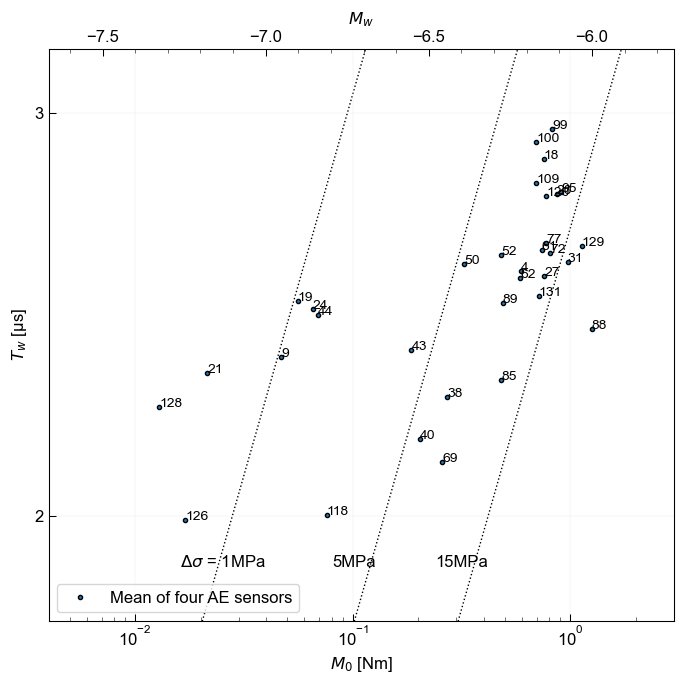

In [40]:
# Plot with event IDs
ifPlotSelfSimLines = True
vs=3600
n_boot = 1000

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

scatter_kws0 = {"s": 0, "edgecolors": "k", "zorder": 1, "alpha": 0.9}
scatter_kws1 = {"s": 90, "edgecolors": "k", "zorder": 1, "alpha": 0.9}
line_kws = {"color": "crimson", "zorder": -3}

tc = [""]
mctype = ["o", "d", "s", "v"]

labelflag = 0

ifPlotMain=1 #1
ifPlotnoQcorr=0
ifPlotAllSensors = 0
ifPlotRegression = 0

for k, datacase in enumerate(datacases_thresh_Nsensor[sorted_inds]):

    tx = []
    for i, stnm in enumerate(AEsensor_list):
    # stnm = AEsensor_list[i]
    # for datacase in datacases:
    
        gougeevent_id = int(datacase.split("__")[1])

        df_sensor = df_sourceparam[(df_sourceparam["Qinv_quart"] == f"{Qinv_quart}") & (df_sourceparam["gougeevent_id"] ==  gougeevent_id) & (df_sourceparam["AEsensor"] ==  int(stnm[2:]))]
        M0_sensor = df_sensor["M0"].values[0]
        Tw_sensor = df_sensor["Tw"].values[0]

        if labelflag < 4:
            label = f"AS{stnm[2:]}"
            labelflag += 1
        else:
            label = ""
            
        if ifPlotAllSensors:
            ax.plot(M0_sensor, Tw_sensor*1e6, marker=mctype[i], c=lc_selected[datacase], label=label, alpha=0.6, zorder=-5)


# sns.regplot uses bootstrap method to obtain the confidence interval
# sns.regplot(x="M0_mean", y="Tw_microsec", data=df_stats_case_droplim, ci=95, fit_reg=True, label="", color="crimson", n_boot=1000,
#             scatter_kws=scatter_kws0, line_kws=line_kws, ax=ax, order=1);
# sns.regplot(x="M0_mean", y="Tw_microsec", data=df_stats_case, ci=95, fit_reg=False, label="Mean of four AE sensors", color="crimson",
#             scatter_kws=scatter_kws1, ax=ax, order=1);

# ax.scatter(df_stats_case_droplim["M0_mean"].values, df_stats_case_droplim["Tw_microsec"].values, 90, marker="o", ec="k", color="crimson", alpha=0.9,
#            label="Mean of four AE sensors", zorder=1)

# ax.scatter(df_stats_case_limevent["M0_mean"].values, df_stats_case_limevent["Tw_microsec"].values, 90, marker="o", ec="k", color="crimson", alpha=0.9,
#            label=None, zorder=1)

# Compute standard error
standarderror_factor = np.sqrt(Nvalidsensors_thresh)

if ifPlotMain:
    # ax.errorbar(df_stats_case["M0_mean"].values, df_stats_case["Tw_microsec"].values, 
    #         yerr = df_stats_case["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_case["M0_std"]/standarderror_factor,
    #         capsize=0, fmt='o', markersize=3, color=scatter_mc[0], markeredgecolor = "black", label="Mean of four AE sensors", zorder=3)
    ax.plot(df_stats_case["M0_mean"].values, df_stats_case["Tw_microsec"].values, 'o',
            markersize=3, color=scatter_mc[0], markeredgecolor = "black", label="Mean of four AE sensors", zorder=3)

    # annotate text
    id_text=[]
    for gid, row in df_stats_case.iterrows():
        ax.annotate(f"{gid}", xy=(row["M0_mean"], row["Tw_microsec"]), xytext=(0, 0), textcoords='offset fontsize', fontsize=10, zorder=5)




if ifPlotnoQcorr:
    if ifPlotMain:
        label_noQcorr = ""
        alpha_noQcorr = 1.0
        mc = [0.9, 0.9, 0.9]
        mec = [0.8, 0.8, 0.8]
        
    else:
        label_noQcorr = "Mean of four AE sensors"
        alpha_noQcorr = 1.0
        mc = scatter_mc[-1]
        mec = "black"
        
    ax.errorbar(df_stats_noQcorr["M0_mean"].values, df_stats_noQcorr["Tw_microsec"].values, 
            yerr = df_stats_noQcorr["Tw_std"].values*1e6/standarderror_factor, xerr = df_stats_noQcorr["M0_std"]/standarderror_factor,
            capsize=3, fmt='o', markersize=9.5, color=mc, markeredgecolor = mec, label=label_noQcorr, alpha=alpha_noQcorr, zorder=1)



# plot the best-fit regression
if ifPlotRegression:
    ax.plot(M0_reg, TR_reg, c=scatter_mc[0], zorder = 2)

# ax.plot(M0_reg, TR_reg_low, c="crimson", ls="--", zorder = -3)
# ax.plot(M0_reg, TR_reg_high, c="crimson", ls="--", zorder = -3)

    ax.text(5e-3, 3.2, f"α={fit_slope:.2f}±{fit_slope_err:.2f}") 

xlimit_scaling = [0.004, 3] #10]check 1/3
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlimit_scaling)
ax.set_ylim([1.8, 3.2]) #[1, 4.0]) #10]) check 1/3
ax.set_yticks([2, 3])
ax.set_yticklabels([2, 3])
# ax.set_yticks([1, 2, 3, 4])
# ax.set_yticklabels([1, 2, 3, 4])

ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("$T_w$ [μs]")

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')
# ax.legend(loc=3)

if not ifPlotAllSensors:
    ax.legend(loc=3)
else:
    ax.legend(loc=3, handlelength=0)


if ifPlotSelfSimLines:
    # M0_selfsim = np.linspace(0, 2, 101)
    M0_selfsim = np.logspace(-3, 1.2, 101)
    
    delsig_list = [1e6, 5e6, 15e6] #[5e6, 10e6, 20e6]
    # delsig_annot_x = [1.35e-2, 2.5e-2, 7.5e-2]
    # delsig_annot_y = [1.55, 1.35, 1.25]
    
    delsig_annot_x = np.array([1.6e-2, 8.1e-2, 2.4e-1]) # update 2025/1/23
    delsig_annot_y = [1.9, 1.9, 1.9] #[1.16, 1.16, 1.16]
    
    # k_rup = 0.32 # P wave for vr = 0.9cs
    delsig_ls = [":", "--"]
    
    # C_k = [0.15, 0.32]
    C_k = [0.32]
    for k, k_rup in enumerate(C_k): # for 0.6vs and 0.9vs
    
        for j, delsig in enumerate(delsig_list):
            TR_selfsim = get_selfsim_scaling(k_rup, vs, delsig, M0_selfsim)
            ax.plot(M0_selfsim, TR_selfsim*1e6, "k", ls=delsig_ls[k], lw=1, zorder=-1)
            
            if j == 0:
                delsigstr = r'$\Delta \sigma$ = {:.0f}MPa'.format(delsig/1e6)
            else:
                delsigstr = '{:.0f}MPa'.format(delsig/1e6)
                
            ax.text(delsig_annot_x[j], delsig_annot_y[j], delsigstr)

# plot measurement limitation
if ifPlotRegression:
    Tw_limit = 2.0
    ax.axhline(Tw_limit, ls="--", c="k", lw=1.0, dashes=(4, 2.8))


#-----------------------#
#--- plot double axis---#
#-----------------------#

# https://pythonmatplotlibtips.blogspot.com/2018/01/add-second-x-axis-below-first-x-axis-python-matplotlib-pyplot.html
ax2 = ax.twiny()
ax2.set_xlabel("$M_w$")
ax2.set_xlim([M02Mw(xlimit_scaling[0]), M02Mw(xlimit_scaling[1])]) # synchronize with the first axis

# major tick
newlabel = np.array([-7.5, -7, -6.5, -6.0,])
ax2.minorticks_on()
ax2.set_xticks(newlabel)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

# plt.suptitle(f'Q{Qinv_quart} water-level={k_waterlevel:.2f}', y=0.98)
plt.tight_layout()

plt.savefig(figdir+f"/debug_STF_M0TRscaling_Regplot_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_selfsimlines{ifPlotSelfSimLines}_fitlog_{fit_method}_{ifPlotAllSensors}{ifPlotRegression}{ifPlotMain}{ifPlotnoQcorr}_withID.png", format="png", dpi=200)
plt.savefig(figdir+f"/debug_STF_M0TRscaling_Regplot_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_selfsimlines{ifPlotSelfSimLines}_fitlog_{fit_method}_{ifPlotAllSensors}{ifPlotRegression}{ifPlotMain}{ifPlotnoQcorr}_withID.pdf")


In [41]:
df_stats_case

,datacase,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std,Tw_microsec
gougeevent_id,,,,,,,,
4,fb03-087__0004,50,4,0.592607,0.178671,0.000003,1.530315e-07,2.558865
9,fb03-087__0009,50,4,0.046991,0.007419,0.000002,3.643121e-07,2.346274
18,fb03-087__0018,50,4,0.755830,0.192507,0.000003,3.100882e-07,2.865571
19,fb03-087__0019,50,4,0.055755,0.016951,0.000002,2.699155e-07,2.484483
20,fb03-087__0020,50,4,0.865466,0.210250,0.000003,1.352659e-07,2.766240
21,fb03-087__0021,50,4,0.021466,0.003270,0.000002,2.162510e-07,2.309987
24,fb03-087__0024,50,4,0.065639,0.021128,0.000002,2.813046e-07,2.464508
27,fb03-087__0027,50,4,0.760101,0.207943,0.000003,1.988136e-07,2.546613
31,fb03-087__0031,50,4,0.972141,0.262485,0.000003,2.161975e-07,2.584020


This is the end of notebook.